In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from loss_dinn_LLM import loss_dinn

torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
torch.backends.cudnn.deterministic = True

covid_cases = pd.read_csv('data.csv')

S = covid_cases['S']
I = covid_cases['I']
D = covid_cases['D']
R = covid_cases['R']
susceptible = []
infected = []
dead = []
recovered = []
timesteps = []

d1 = covid_cases['S']
d2 = covid_cases['I']
d3 = covid_cases['D']
d4 = covid_cases['R']
d5 = covid_cases['t']

for item in range(len(d5)):
    if item % 1 == 0:
        susceptible.append(d1[item])
        infected.append(d2[item])
        dead.append(d3[item])
        recovered.append(d4[item])
        timesteps.append(d5[item])

x = 180


class DINN(nn.Module):
    def __init__(self, t, S_data, I_data, D_data, R_data):
        super(DINN, self).__init__()
        self.N = 6e6
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t), 1))
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = []

        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_tilda = torch.nn.Parameter(
            torch.rand(1, requires_grad=True))

        self.S_max = max(self.S)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)

        self.m1 = torch.zeros((len(self.t), 4))
        self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 4))
        self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 4))
        self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 4))
        self.m4[:, 3] = 1

        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend([self.beta_tilda, self.gamma_tilda])

    @property
    def beta(self):
        return torch.tanh(self.beta_tilda)

    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda)

    class Net_sidr(nn.Module):
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()
            self.fc1 = nn.Linear(1, 200)
            self.fc2 = nn.Linear(200, 100)
            self.out = nn.Linear(100, 4)
            self.out_alpha = nn.Linear(100, 1)

        def forward(self, t_batch):
            x = F.relu(self.fc1(t_batch))
            x = F.tanh(self.fc2(x))
            sidr = self.out(x)
            alpha = self.out_alpha(x)
            return sidr, alpha

    def net_f(self, t_batch):
        sidr_hat, alpha_hat = self.net_sidr(t_batch)

        S_hat, I_hat, D_hat, R_hat = sidr_hat[:,
                                              0], sidr_hat[:, 1], sidr_hat[:, 2], sidr_hat[:, 3]

        # S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        # I_t
        sidr_hat.backward(self.m2, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        # D_t
        sidr_hat.backward(self.m3, retain_graph=True)
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        # R_t
        sidr_hat.backward(self.m4, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        # Unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        D = self.D_min + (self.D_max - self.D_min) * D_hat
        R = self.R_min + (self.R_max - self.R_min) * R_hat

        f1_hat = S_hat_t - (-(alpha_hat / self.N) * S * I) / \
            (self.S_max - self.S_min)
        f2_hat = I_hat_t - ((alpha_hat / self.N) * S * I - self.beta.squeeze()
                            * I - self.gamma * I) / (self.I_max - self.I_min)
        f3_hat = D_hat_t - (self.gamma * I) / (self.D_max - self.D_min)
        f4_hat = R_hat_t - (self.beta.squeeze() * I) / \
            (self.R_max - self.R_min)

        return f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat, alpha_hat

    def train(self, n_epochs, regul):
        # Train
        print('\nStarting training...\n')

        for epoch in range(n_epochs):
            S_pred_list = []
            I_pred_list = []
            D_pred_list = []
            R_pred_list = []
            alpha_pred_list = []

            f1, f2, f3, f4, S_pred, I_pred, D_pred, R_pred, alpha_pred = self.net_f(
                self.t_batch)
            self.optimizer.zero_grad()

            S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred)
            I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
            D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
            R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)
            alpha_pred_list.append(alpha_pred)
            loss = loss_dinn(self.S_hat[:x], S_pred[:x],
                             self.I_hat[:x], I_pred[:x],
                             self.D_hat[:x], D_pred[:x],
                             self.R_hat[:x], R_pred[:x],
                             f1[:x],
                             f2[:x],
                             f3[:x],
                             f4[:x], I_pred[-1])
            # print("!!!!!!!!!!!!")
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            self.losses.append(loss.item())

            if epoch % 1000 == 0:
                print('\nEpoch ', epoch)

            # Loss + model parameters update
            if epoch % 4000 == 0:
                print('Loss is: ', loss)
                print('Epoch: ', epoch)
                print('dinn.beta', self.beta)
                print('dinn.gamma', self.gamma)
                print(alpha_pred.shape)

        return S_pred_list, I_pred_list, D_pred_list, R_pred_list, alpha_pred_list

    def predict(self, t_values=None):
        """Получить прогноз модели для заданных временных точек"""
        if t_values is None:
            t_values = self.t_float

        t_batch = torch.reshape(t_values, (len(t_values), 1))

        with torch.no_grad():
            sidr_hat, alpha_hat = self.net_sidr(t_batch)
            S_hat, I_hat, D_hat, R_hat = sidr_hat[:,
                                                  0], sidr_hat[:, 1], sidr_hat[:, 2], sidr_hat[:, 3]

            # Денормализация
            S_pred = self.S_min + (self.S_max - self.S_min) * S_hat
            I_pred = self.I_min + (self.I_max - self.I_min) * I_hat
            D_pred = self.D_min + (self.D_max - self.D_min) * D_hat
            R_pred = self.R_min + (self.R_max - self.R_min) * R_hat

        return S_pred, I_pred, D_pred, R_pred, alpha_hat

In [3]:
def save_model(model, filepath):
    """Сохранить модель полностью"""
    torch.save({
        'model_state_dict': model.state_dict(),
        'beta_tilda': model.beta_tilda,
        'gamma_tilda': model.gamma_tilda,
        'S_max': model.S_max,
        'I_max': model.I_max,
        'D_max': model.D_max,
        'R_max': model.R_max,
        'S_min': model.S_min,
        'I_min': model.I_min,
        'D_min': model.D_min,
        'R_min': model.R_min,
        't': model.t,
        'S': model.S,
        'I': model.I,
        'D': model.D,
        'R': model.R
    }, filepath)
    print(f"Model saved to {filepath}")

In [4]:
def load_model(filepath, t, S_data, I_data, D_data, R_data):
    """Загрузить модель"""
    checkpoint = torch.load(filepath)

    # Создаем экземпляр модели
    model = DINN(t, S_data, I_data, D_data, R_data)

    # Загружаем параметры
    model.load_state_dict(checkpoint['model_state_dict'])
    model.beta_tilda = checkpoint['beta_tilda']
    model.gamma_tilda = checkpoint['gamma_tilda']
    model.S_max = checkpoint['S_max']
    model.I_max = checkpoint['I_max']
    model.D_max = checkpoint['D_max']
    model.R_max = checkpoint['R_max']
    model.S_min = checkpoint['S_min']
    model.I_min = checkpoint['I_min']
    model.D_min = checkpoint['D_min']
    model.R_min = checkpoint['R_min']
    model.t = checkpoint['t']
    model.S = checkpoint['S']
    model.I = checkpoint['I']
    model.D = checkpoint['D']
    model.R = checkpoint['R']

    # Обновляем производные атрибуты
    model.t_float = model.t.float()
    model.t_batch = torch.reshape(model.t_float, (len(model.t), 1))
    model.S_hat = (model.S - model.S_min) / (model.S_max - model.S_min)
    model.I_hat = (model.I - model.I_min) / (model.I_max - model.I_min)
    model.D_hat = (model.D - model.D_min) / (model.D_max - model.D_min)
    model.R_hat = (model.R - model.R_min) / (model.R_max - model.R_min)

    print(f"Model loaded from {filepath}")
    return model

In [4]:
dinn = DINN(timesteps, susceptible, infected, dead, recovered)

learning_rate = 1e-5
optimizer = optim.Adam(dinn.params, lr=learning_rate)
dinn.optimizer = optimizer


scheduler = torch.optim.lr_scheduler.CyclicLR(
    dinn.optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler


S_pred_list, I_pred_list, D_pred_list, R_pred_list, alpha_pred_list = dinn.train(
    100000, regul=0.8)


Starting training...


Epoch  0
Loss is:  tensor(0.6599, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:  0
dinn.beta tensor([0.2877], grad_fn=<TanhBackward0>)
dinn.gamma tensor([0.4750], grad_fn=<TanhBackward0>)
torch.Size([369, 1])

Epoch  1000

Epoch  2000

Epoch  3000

Epoch  4000
Loss is:  tensor(0.1205, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:  4000
dinn.beta tensor([0.2738], grad_fn=<TanhBackward0>)
dinn.gamma tensor([0.4430], grad_fn=<TanhBackward0>)
torch.Size([369, 1])

Epoch  5000

Epoch  6000

Epoch  7000

Epoch  8000
Loss is:  tensor(0.1061, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:  8000
dinn.beta tensor([0.2447], grad_fn=<TanhBackward0>)
dinn.gamma tensor([0.4089], grad_fn=<TanhBackward0>)
torch.Size([369, 1])

Epoch  9000

Epoch  10000

Epoch  11000

Epoch  12000
Loss is:  tensor(0.0915, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:  12000
dinn.beta tensor([0.2074], grad_fn=<TanhBackward0>)
dinn.gamma tensor([0.3737], grad_fn=<TanhBackwar

In [5]:
save_model(dinn, './saved_models/dinn_1.pth')

Model saved to ./saved_models/dinn_1.pth


In [5]:
loaded_dinn = load_model('./saved_models/dinn_2.pth',
                         timesteps, susceptible, infected, dead, recovered)

Model loaded from ./saved_models/dinn_2.pth


In [6]:
S_pred, I_pred, D_pred, R_pred, alpha_pred = loaded_dinn.predict()

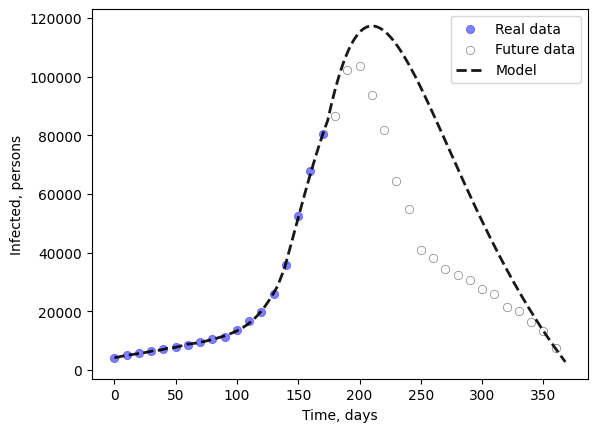

In [8]:
plt.scatter(timesteps[:x][::10], infected[:x][::10],
            c='blue', alpha=0.5, lw=0.5, label='Real data')
plt.scatter(timesteps[x:][::10], infected[x:][::10], c='white',
            edgecolors='black', alpha=0.5, lw=0.5, label='Future data')
plt.plot(timesteps, I_pred_list[0].detach().numpy(
), 'black', alpha=0.9, lw=2, label='Model', linestyle='dashed')
plt.xlabel("Time, days")
plt.ylabel("Infected, persons")
plt.legend()
plt.show()
# plt.savefig(
#     "./results/PINN_py_Infected_persons_claude_3.png", dpi=300)
# save_dir = "saved_results_arrays"

# timesteps_arr = np.array(timesteps)
# infected_arr = np.array(infected)
# I_pred_arr = I_pred_list[0].detach().numpy()

# np.save(os.path.join(save_dir, "timesteps.npy"), timesteps_arr)
# np.save(os.path.join(save_dir, "infected.npy"), infected_arr)
# np.save(os.path.join(save_dir, "I_pred_primary.npy"), I_pred_arr)
# np.save(os.path.join(save_dir, "I_pred_deekseek.npy"), I_pred_arr)
# np.save(os.path.join(save_dir, "I_pred_perplexity.npy"), I_pred_arr)
# np.save(os.path.join(save_dir, "I_pred_perplexity_2.npy"), I_pred_arr)
# np.save(os.path.join(save_dir, "I_pred_meta_llama_1.npy"), I_pred_arr)
# np.save(os.path.join(save_dir, "I_pred_gpt4_1_1.npy"), I_pred_arr)
# np.save(os.path.join(save_dir, "I_pred_claude_2.npy"), I_pred_arr)
# np.save(os.path.join(save_dir, "I_pred_claude_3.npy"), I_pred_arr)

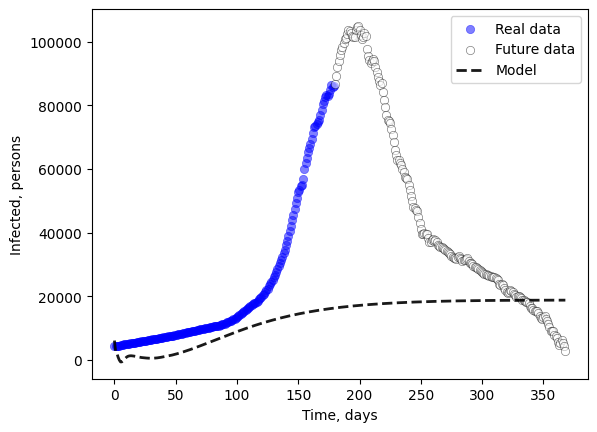

In [7]:
plt.scatter(timesteps[:x][::], infected[:x][::],
            c='blue', alpha=0.5, lw=0.5, label='Real data')
plt.scatter(timesteps[x:][::], infected[x:][::], c='white',
            edgecolors='black', alpha=0.5, lw=0.5, label='Future data')
plt.plot(timesteps, I_pred.detach().numpy(
), 'black', alpha=0.9, lw=2, label='Model', linestyle='dashed')
plt.xlabel("Time, days")
plt.ylabel("Infected, persons")
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def calculate_metrics(y_true, y_pred):
    """
    Calculate regression metrics

    Parameters:
    y_true: array-like, true values
    y_pred: array-like, predicted values

    Returns:
    dict: Dictionary with MAE, MSE, RMSE, R2 metrics
    """
    # Convert to numpy arrays if they are tensors
    if torch.is_tensor(y_true):
        y_true = y_true.detach().numpy()
    if torch.is_tensor(y_pred):
        y_pred = y_pred.detach().numpy()

    # Ensure they are 1D arrays
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

    return metrics

In [10]:
metrics_I = calculate_metrics(infected[x:187], I_pred[x:187])
metrics_I

{'MAE': 76948.265625,
 'MSE': 5936389120.0,
 'RMSE': np.float64(77047.96635862623),
 'R2': -368.2068176269531}

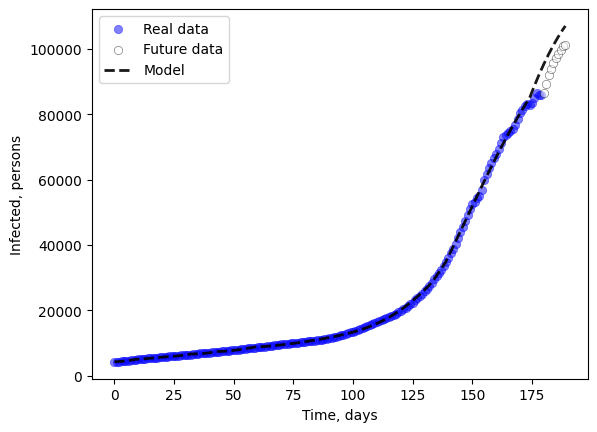

In [27]:
plt.scatter(timesteps[:x][:190:], infected[:x][:190:],
            c='blue', alpha=0.5, lw=0.5, label='Real data')
plt.scatter(timesteps[x:190][::], infected[x:190][::], c='white',
            edgecolors='black', alpha=0.5, lw=0.5, label='Future data')
plt.plot(timesteps[:190], I_pred.detach().numpy(
)[:190], 'black', alpha=0.9, lw=2, label='Model', linestyle='dashed')
plt.xlabel("Time, days")
plt.ylabel("Infected, persons")
plt.legend()
plt.show()

In [8]:
metrics_I = calculate_metrics(infected[x:], I_pred[:])

NameError: name 'calculate_metrics' is not defined

In [ ]:
# metrics_S = calculate_metrics(susceptible, S_pred)

# metrics_D = calculate_metrics(dead, D_pred)
# metrics_R = calculate_metrics(recovered, R_pred)